In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB

In [2]:
!pip install prophet

In [3]:
!pip install lightgbm

In [4]:
#Optional - Uncomment if using google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = "/content/drive/MyDrive/ADU Talk/Preprocessed_dataset.csv" #Add path to dataset here "Preprocessed_dataset.csv"

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from darts import TimeSeries
from darts.models import RegressionModel
import lightgbm as lgbm

In [16]:
def display_results_DARTS(ytest,preds):
    # Plot the daily prediction vs real
    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(figsize=(12,8))
    ytest.plot()
    preds.plot()
    plt.title("Real vs Prediction")
    plt.legend(['Real','Pred'])
    plt.show()

    #Plot the % difference between real and pred
    ypred=preds.pd_dataframe()
    ytrue=ytest.pd_dataframe()
    r=pd.concat([ypred,ytrue],axis=1)
    r.columns=['Predicted','Real']
    r['Diff']=ypred-ytrue
    r['%diff']=abs((r['Diff'])/r['Real'])*100

    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(figsize=(12,8))
    plt.title("LGBM Regressor % diff distribution")
    sns.histplot(r['%diff'],bins=list(range(0,51,5)))
    plt.show()

In [32]:
def display_results_Prophet(test,forecast):
    plt.figure(figsize=(12,8))
    plt.plot(test['y'],label='Real')
    plt.plot(forecast['yhat'],label='Pred')
    plt.fill_between(list(range(len(test))),forecast['yhat_lower'],forecast['yhat_upper'],label='Conf Int',color='orange',alpha=0.5)
    plt.title("Real vs Prediction")
    plt.legend()
    plt.show()

    #Plot the % differences
    rfeats=forecast[['ds','yhat_lower','yhat_upper','yhat']]
    rfeats=pd.concat([rfeats,test.reset_index().y],axis=1)
    rfeats.columns=['Date','Min','Max','Pred','Real']
    rfeats['PredDiff']=abs(rfeats['Real']-rfeats['Pred'])
    rfeats['%diff_Pred']=abs((rfeats['Real']-rfeats['Pred'])/rfeats['Real'])*100

    plt.hist(rfeats['%diff_Pred'],bins=list(range(0,51,5)))
    plt.title('Prophet w Feats % Difference per day')
    plt.xlabel("% difference")
    plt.ylabel("Number of days")
    plt.show()

In [9]:
df=pd.read_csv(dataset_path)
df

,Date,Sales,Discount,Holiday,weekOfYear,weekOfMonth,dayOfWeek,dayOfWeekLabel
0,2018-01-01,15345484.50,1,1,1,0,Monday,1
1,2018-01-02,19592415.00,1,0,1,0,Tuesday,2
2,2018-01-03,18652527.00,1,0,1,0,Wednesday,3
3,2018-01-04,19956267.00,1,0,1,0,Thursday,4
4,2018-01-05,22902651.00,1,0,1,0,Friday,5
...,...,...,...,...,...,...,...,...
511,2019-05-27,17197023.00,1,0,21,4,Monday,1
512,2019-05-28,18652065.00,1,0,21,4,Tuesday,2
513,2019-05-29,16213497.00,1,0,21,4,Wednesday,3
514,2019-05-30,16082139.00,0,0,21,4,Thursday,4


# DARTS

## Make Dataset

In [10]:
y=TimeSeries.from_dataframe(df, time_col='Date', value_cols=['Sales'],freq='D')
y

<TimeSeries (DataArray) (Date: 516, component: 1, sample: 1)>
array([[[15345484.49999999]],

       [[19592415.        ]],

       [[18652527.        ]],

       [[19956267.        ]],

       [[22902651.        ]],

       [[16351956.        ]],

       [[18219249.        ]],

       [[15641283.        ]],

       [[14197074.        ]],

       [[14712108.        ]],

...

       [[14958597.        ]],

       [[14721366.        ]],

       [[15948156.        ]],

       [[19696350.        ]],

       [[20169666.        ]],

       [[17197023.        ]],

       [[18652065.        ]],

       [[16213497.        ]],

       [[16082139.        ]],

       [[15601824.99      ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2018-01-01 2018-01-02 ... 2019-05-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [11]:
ytrain,ytest = y[:413],y[413:]
len(ytrain),len(ytest)

(413, 103)

## Random Lags

In [12]:
model=RegressionModel(lags=[-1,-7,-14,-30], model=lgbm.LGBMRegressor())
model.fit(series=ytrain)
preds=model.predict(n=103,series=ytrain) #Predict 103 days after ytrain ends
preds

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 383, number of used features: 4
[LightGBM] [Info] Start training from score 15515559.026436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

<TimeSeries (DataArray) (Date: 103, component: 1, sample: 1)>
array([[[17629411.98096932]],

       [[17946420.74214701]],

       [[17094868.75858138]],

       [[16343188.8625054 ]],

       [[14268569.63625116]],

       [[15536020.51790004]],

       [[14887015.54465437]],

       [[16824467.1605224 ]],

       [[18557010.48068739]],

       [[19743831.6456161 ]],

...

       [[15148072.0697858 ]],

       [[14170105.0191017 ]],

       [[16073120.33187391]],

       [[15564782.93163824]],

       [[15325019.54319669]],

       [[15004118.15624862]],

       [[15219256.01575604]],

       [[15094934.22617496]],

       [[14978754.24804592]],

       [[14428385.88424574]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2019-02-18 2019-02-19 ... 2019-05-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

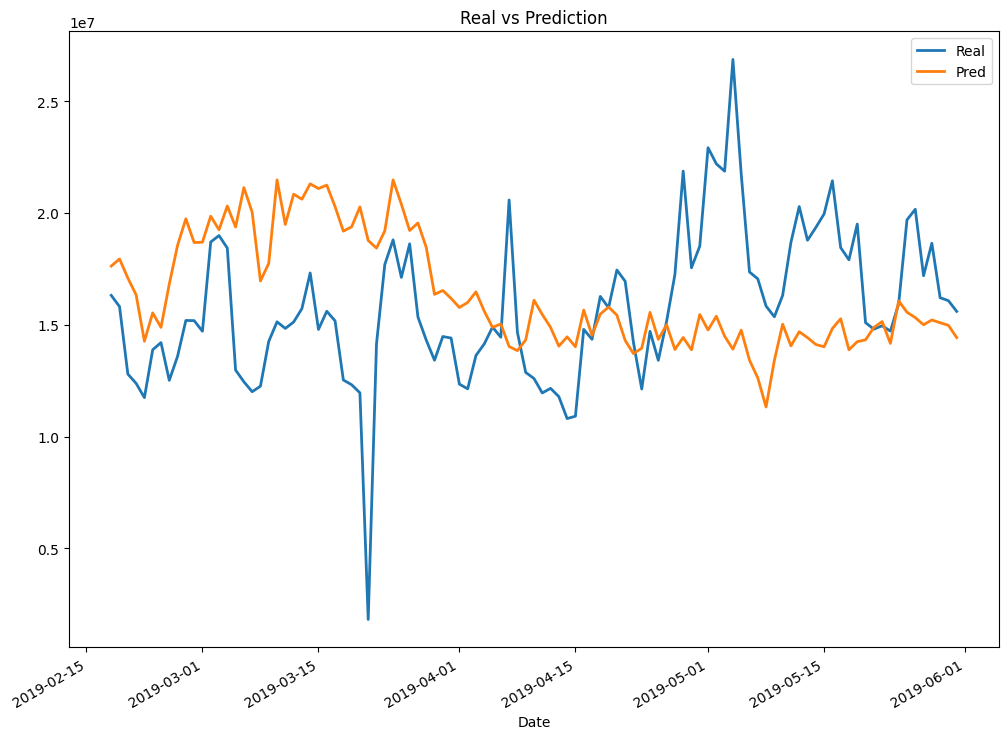

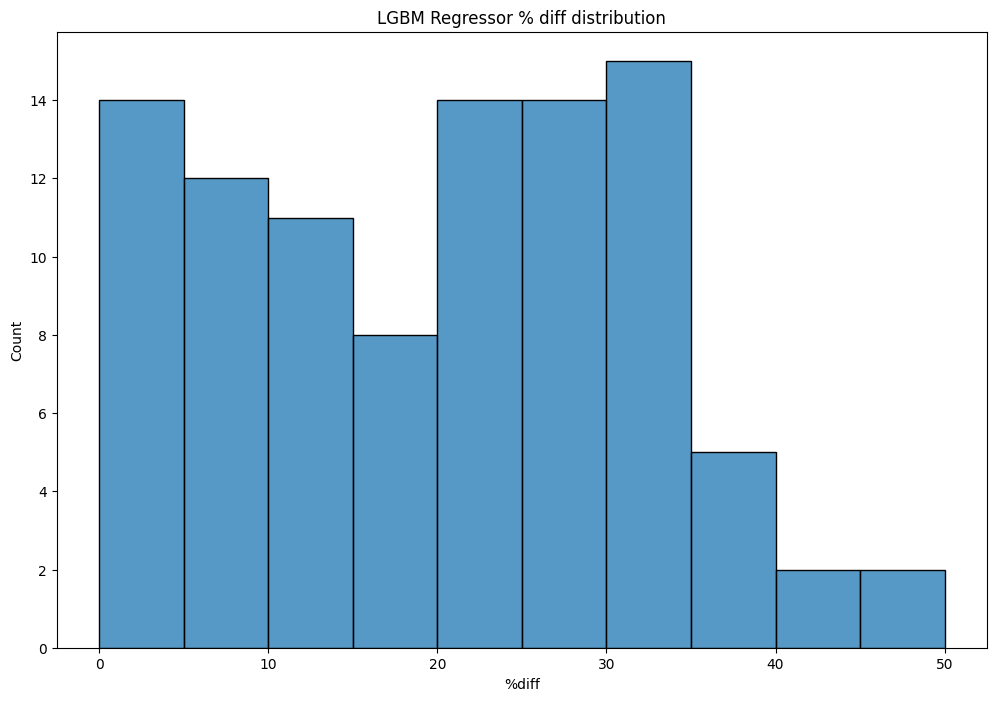

In [17]:
display_results_DARTS(ytest,preds)

## Try using better lags based on ACF:

In [18]:
model=RegressionModel(lags=[-1,-2,-3,-12,-13,-14,-15], model=lgbm.LGBMRegressor())
model.fit(series=ytrain)
preds=model.predict(n=103,series=ytrain) #Predict 103 days after ytrain ends
preds

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 7
[LightGBM] [Info] Start training from score 15503300.374686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

<TimeSeries (DataArray) (Date: 103, component: 1, sample: 1)>
array([[[15657790.75089714]],

       [[15022074.77821885]],

       [[15779023.28486265]],

       [[14989700.18996506]],

       [[14383080.44131471]],

       [[15848875.53205007]],

       [[16487674.55032245]],

       [[16041004.7410573 ]],

       [[15723082.0121806 ]],

       [[16017190.50972489]],

...

       [[15469008.88488187]],

       [[13358374.46295417]],

       [[12217562.34291641]],

       [[14350562.29395511]],

       [[14731615.09440305]],

       [[15377004.85539007]],

       [[14774542.23880814]],

       [[16316140.50428304]],

       [[15870949.94133884]],

       [[17370760.59694367]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2019-02-18 2019-02-19 ... 2019-05-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

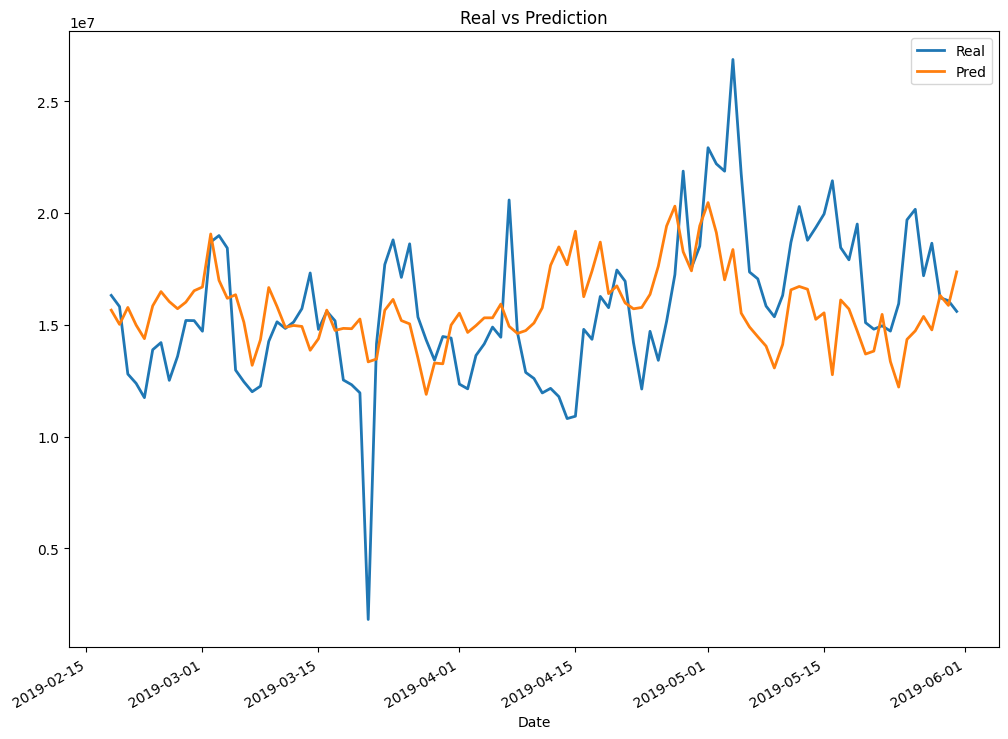

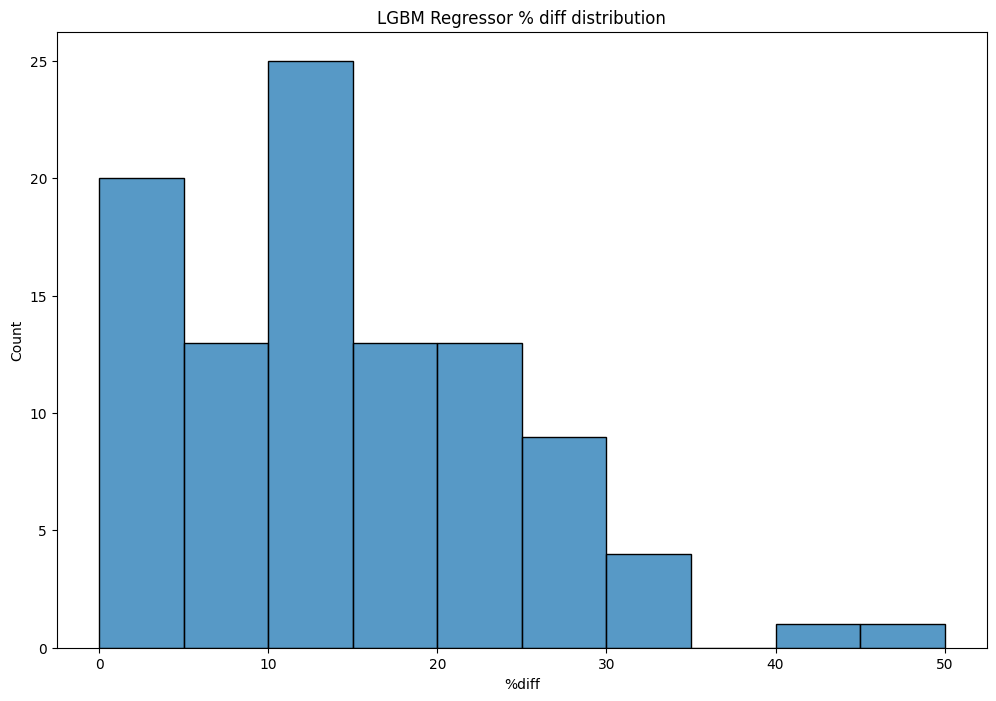

In [19]:
display_results_DARTS(ytest,preds)

## Adding other features

In [20]:
futureCov=TimeSeries.from_dataframe(df,value_cols=['Discount','Holiday','weekOfYear','weekOfMonth','dayOfWeekLabel'],
                                    time_col='Date',freq='D')
futureCov

<TimeSeries (DataArray) (Date: 516, component: 5, sample: 1)>
array([[[ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.]],

       [[ 1.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 2.]],

       [[ 1.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 3.]],

       ...,

       [[ 1.],
        [ 0.],
        [21.],
        [ 4.],
        [ 3.]],

       [[ 0.],
        [ 0.],
        [21.],
        [ 4.],
        [ 4.]],

       [[ 0.],
        [ 1.],
        [21.],
        [ 4.],
        [ 5.]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2018-01-01 2018-01-02 ... 2019-05-31
  * component  (component) object 'Discount' 'Holiday' ... 'dayOfWeekLabel'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [21]:
model=RegressionModel(lags=[-1,-2,-3,-12,-13,-14,-15],lags_future_covariates=[0], model=lgbm.LGBMRegressor())
model.fit(ytrain,future_covariates=futureCov)
preds=model.predict(n=103,series=ytrain,future_covariates=futureCov)
preds

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 12
[LightGBM] [Info] Start training from score 15503300.374686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

<TimeSeries (DataArray) (Date: 103, component: 1, sample: 1)>
array([[[16020830.24587773]],

       [[15284623.28795134]],

       [[13015013.8618842 ]],

       [[13406743.62653771]],

       [[13186088.55639284]],

       [[14240809.17299782]],

       [[15898806.99683326]],

       [[13812100.85361008]],

       [[13608388.29120041]],

       [[15248876.81152829]],

...

       [[13300648.79146951]],

       [[14004719.08046513]],

       [[13892764.70497315]],

       [[17386231.39951183]],

       [[20558966.78137037]],

       [[17419853.32905969]],

       [[18372775.76337961]],

       [[18828015.28136317]],

       [[15633401.3115074 ]],

       [[14236278.18693512]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2019-02-18 2019-02-19 ... 2019-05-31
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

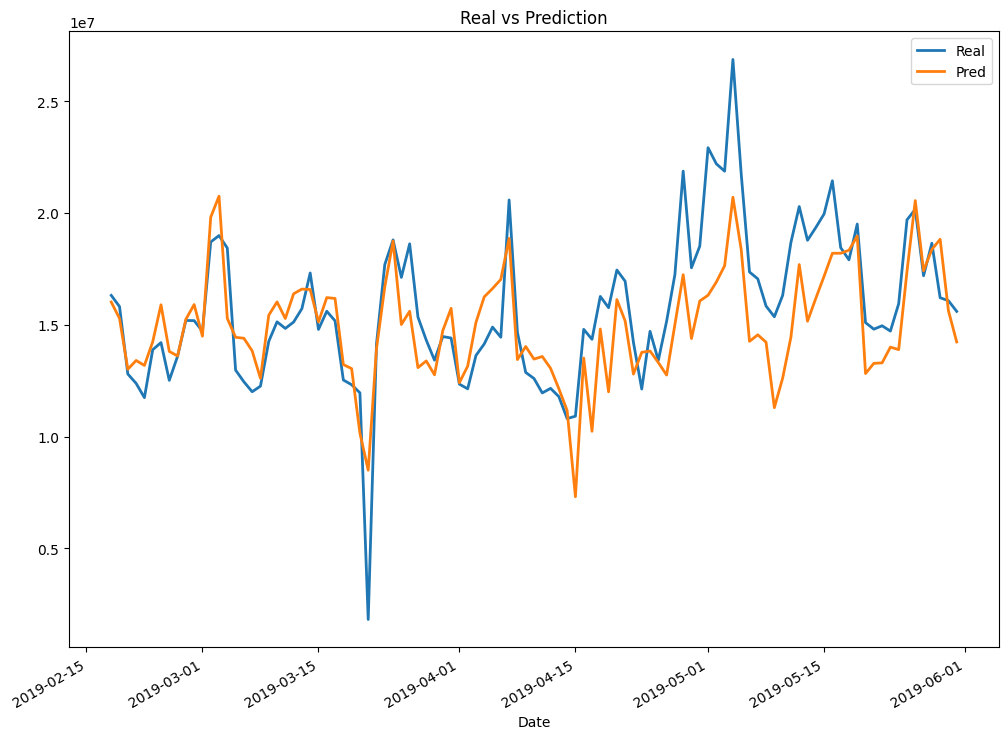

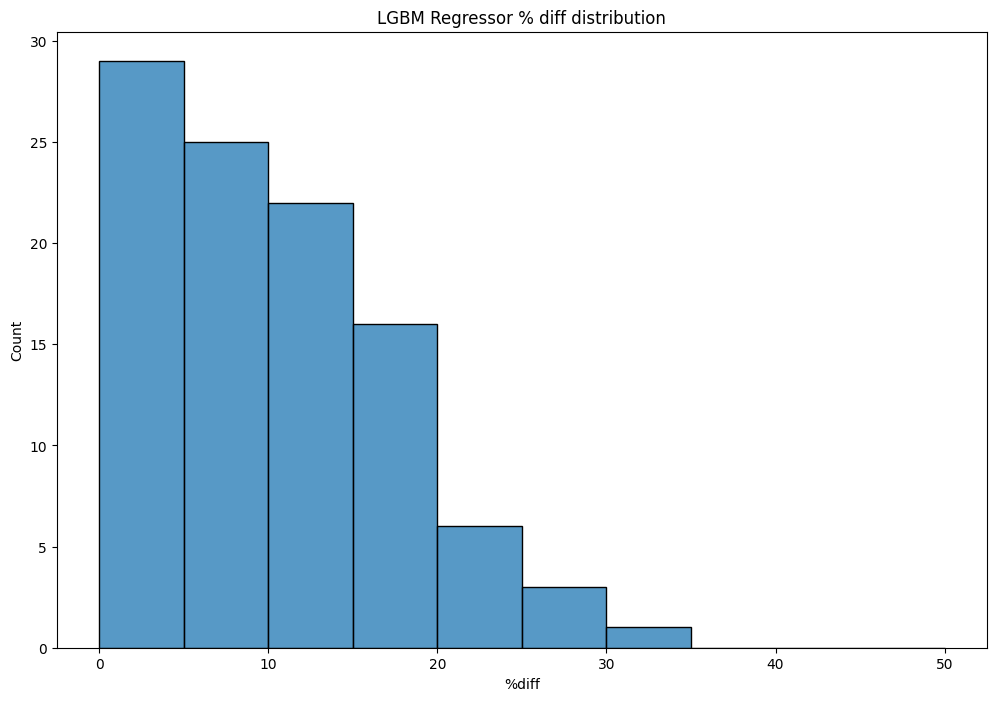

In [22]:
display_results_DARTS(ytest,preds)

# Prophet

In [23]:
from prophet import Prophet

In [24]:
df.columns

Index(['Date', 'Sales', 'Discount', 'Holiday', 'weekOfYear', 'weekOfMonth',
       'dayOfWeek', 'dayOfWeekLabel'],
      dtype='object')

In [25]:
prophetdf=df.copy()
prophetdf.drop('dayOfWeek',axis=1,inplace=True)
prophetdf.columns=['ds', 'y', 'Discount', 'Holiday', 'weekOfYear', 'weekOfMonth', 'dayOfWeekLabel']
prophetdf

,ds,y,Discount,Holiday,weekOfYear,weekOfMonth,dayOfWeekLabel
0,2018-01-01,15345484.50,1,1,1,0,1
1,2018-01-02,19592415.00,1,0,1,0,2
2,2018-01-03,18652527.00,1,0,1,0,3
3,2018-01-04,19956267.00,1,0,1,0,4
4,2018-01-05,22902651.00,1,0,1,0,5
...,...,...,...,...,...,...,...
511,2019-05-27,17197023.00,1,0,21,4,1
512,2019-05-28,18652065.00,1,0,21,4,2
513,2019-05-29,16213497.00,1,0,21,4,3
514,2019-05-30,16082139.00,0,0,21,4,4


In [26]:
train,test=prophetdf[:413],prophetdf[413:].reset_index(drop=True)
train.head()

,ds,y,Discount,Holiday,weekOfYear,weekOfMonth,dayOfWeekLabel
0,2018-01-01,15345484.5,1,1,1,0,1
1,2018-01-02,19592415.0,1,0,1,0,2
2,2018-01-03,18652527.0,1,0,1,0,3
3,2018-01-04,19956267.0,1,0,1,0,4
4,2018-01-05,22902651.0,1,0,1,0,5


In [27]:
model = Prophet()
#Add other regressors to allow for better prediction
model.add_regressor('Discount')
model.add_regressor('Holiday')
model.add_regressor('dayOfWeekLabel')
model.add_regressor('weekOfYear')
model.add_regressor('weekOfMonth')
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwkc55iw/ut538ggh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgwkc55iw/cgbdj6k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73181', 'data', 'file=/tmp/tmpgwkc55iw/ut538ggh.json', 'init=/tmp/tmpgwkc55iw/cgbdj6k7.json', 'output', 'file=/tmp/tmpgwkc55iw/prophet_model1k72xhns/prophet_model-20240306211925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
forecast = model.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Discount,Discount_lower,Discount_upper,Holiday,...,weekOfYear,weekOfYear_lower,weekOfYear_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-18,1.475512e+07,1.525207e+07,2.117526e+07,1.475512e+07,1.475512e+07,3.180936e+06,3.180936e+06,3.180936e+06,0.000000e+00,...,265036.49383,265036.49383,265036.49383,7.288902e+05,7.288902e+05,7.288902e+05,0.0,0.0,0.0,1.808906e+07
1,2019-02-19,1.475586e+07,1.102614e+07,1.711963e+07,1.475586e+07,1.475586e+07,3.180936e+06,3.180936e+06,3.180936e+06,-3.489119e+06,...,265036.49383,265036.49383,265036.49383,-2.822906e+05,-2.822906e+05,-2.822906e+05,0.0,0.0,0.0,1.386933e+07
2,2019-02-20,1.475661e+07,1.148256e+07,1.718312e+07,1.475661e+07,1.475661e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,265036.49383,265036.49383,265036.49383,-4.854559e+05,-4.854559e+05,-4.854559e+05,0.0,0.0,0.0,1.425492e+07
3,2019-02-21,1.475735e+07,1.104056e+07,1.692804e+07,1.475735e+07,1.475735e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,265036.49383,265036.49383,265036.49383,-9.979403e+05,-9.979403e+05,-9.979403e+05,0.0,0.0,0.0,1.402301e+07
4,2019-02-22,1.475810e+07,1.090158e+07,1.672899e+07,1.475810e+07,1.475810e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,265036.49383,265036.49383,265036.49383,-1.431274e+06,-1.431274e+06,-1.431274e+06,0.0,0.0,0.0,1.387025e+07


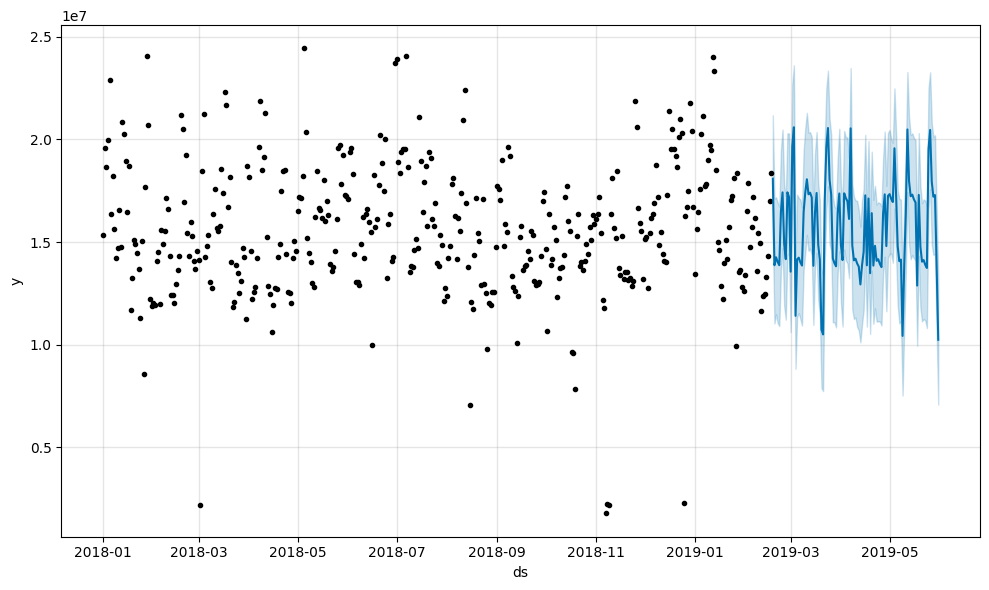

In [29]:
model.plot(forecast) #Plot the trained points (black dots) and the new predictions (blue lines)

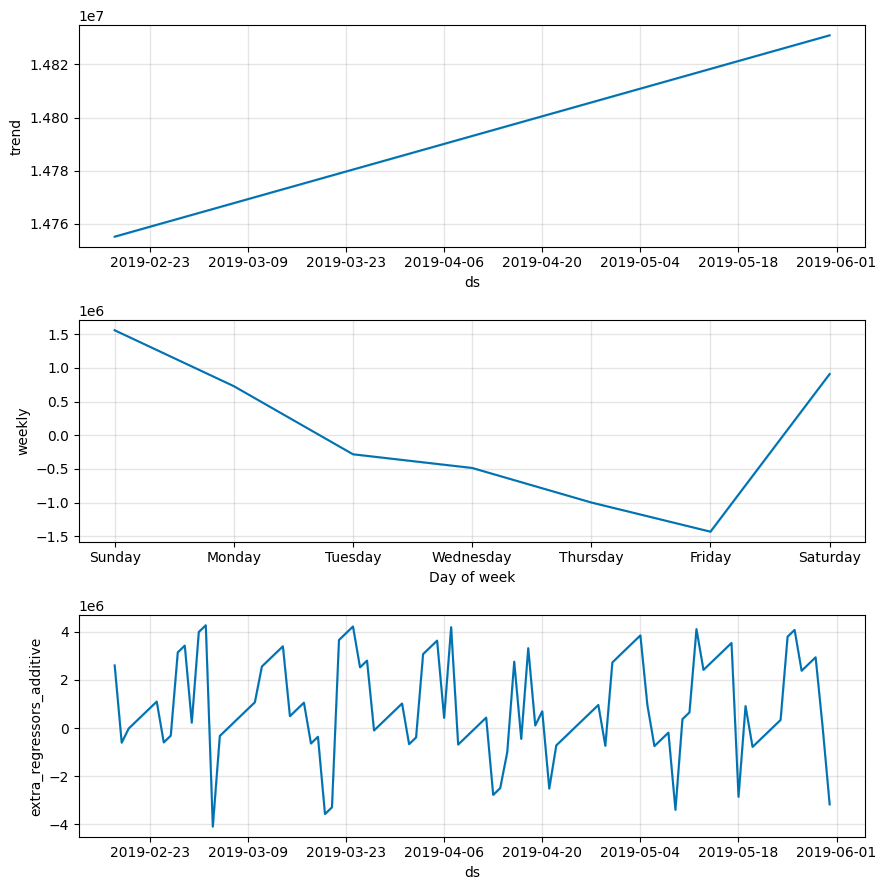

In [30]:
model.plot_components(forecast) #More details about trends daily/weekly/yearly

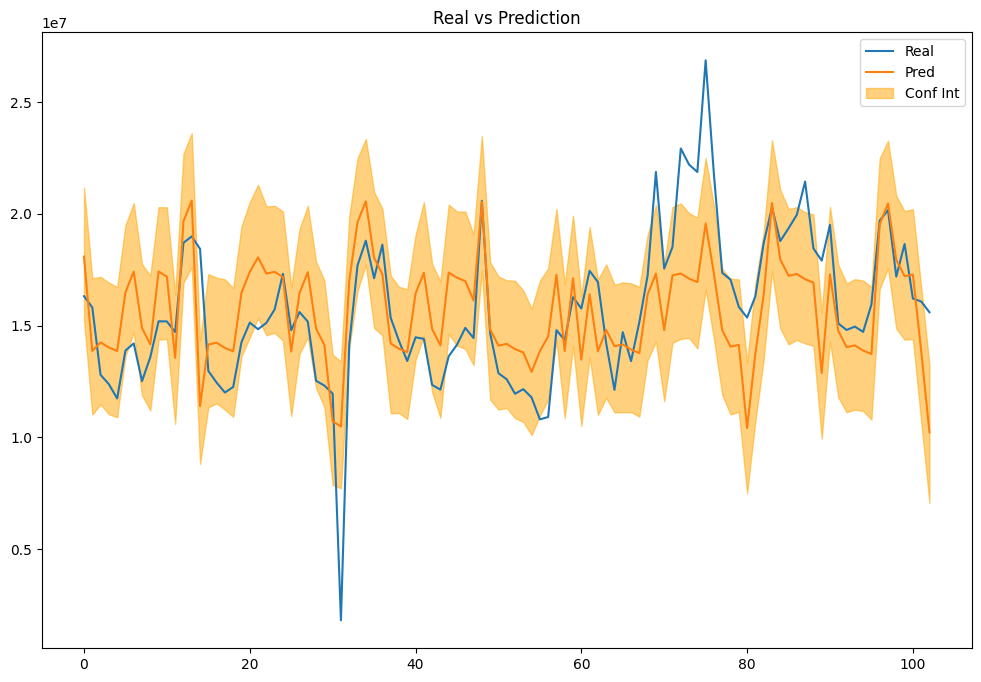

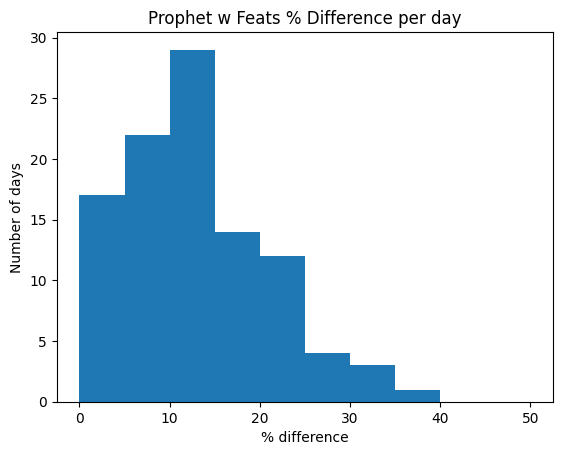

In [33]:
display_results_Prophet(test,forecast)